In [13]:
"""
Qualitatively replicate: 

[1] Elman, J. L. (1990). Finding structure in time. 
Cognitive Science, 14(2), 179–211. 
https://doi.org/10.1016/0364-0213(90)90002-E

[2] Saffran, J. R., Aslin, R. N., & Newport, E. L. (1996). Statistical learning by 8-month-old infants. 
Science, 274(5294), 1926–1928. 
https://doi.org/10.1126/science.274.5294.1926
"""
import psyneulink as pnl
import os 
import time 
import string 
import warnings
import itertools
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set(style='white', context='poster', font_scale=.8, rc={"lines.linewidth": 2})

seed_val = 0
np.random.seed(seed_val)

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [2]:
all_letters = string.ascii_lowercase

# define all vocabs
chunk_size = 4
all_vocabs = [
    all_letters[i:i + chunk_size]
    for i in range(0, len(all_letters), chunk_size) 
]
print(f'All vocabs:\n{all_vocabs}')

All vocabs:
['abcd', 'efgh', 'ijkl', 'mnop', 'qrst', 'uvwx', 'yz']


In [3]:
# gen seqs, given some vocabs
def gen_story(all_vocabs, seq_len): 
    n_vocabs = len(all_vocabs)
    seq_ids = np.random.randint(n_vocabs, size=seq_len)
    seq = [all_vocabs[i] for i in seq_ids]
    # integer representation
    seq_int = [
        [all_letters.index(letter) for letter in vocab]
        for vocab in seq
    ]
    return seq, seq_int

seq_len = 12
seq, seq_int = gen_story(all_vocabs, seq_len)
print(f'Here\'s a "story":\n{seq}')
print(f'The corresponding int representation:\n{seq_int}')

Here's a "story":
['qrst', 'uvwx', 'abcd', 'mnop', 'mnop', 'mnop', 'efgh', 'mnop', 'uvwx', 'ijkl', 'qrst', 'yz']
The corresponding int representation:
[[16, 17, 18, 19], [20, 21, 22, 23], [0, 1, 2, 3], [12, 13, 14, 15], [12, 13, 14, 15], [12, 13, 14, 15], [4, 5, 6, 7], [12, 13, 14, 15], [20, 21, 22, 23], [8, 9, 10, 11], [16, 17, 18, 19], [24, 25]]


In [4]:
# vectorize the input 
def onehot_transform(seq_int_): 
    # get the unit of representation
    n_letters = len(all_letters)
    all_letters_ohe_template = np.reshape(np.arange(n_letters),newshape=(-1,1))
    # init one hot encoder
    ohe = OneHotEncoder(n_values=n_letters, sparse=False)
    ohe.fit(all_letters_ohe_template)
    # reformat the sequence
    seq_int_ = [np.reshape(vocab, newshape=(-1,1)) for vocab in seq_int_]
    # transform to one hot 
    seq_ohe = [ohe.transform(vocab) for vocab in seq_int_]
    return seq_ohe

seq_ohe = onehot_transform(seq_int)

Text(0.5, 1.0, 'The one hot representation of "qrst"')

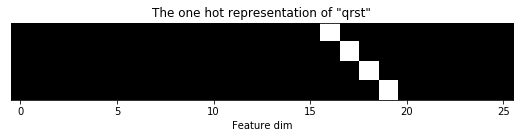

In [5]:
f, ax = plt.subplots(1,1, figsize=(9,5))

vocab_id = 0

ax.imshow(seq_ohe[vocab_id], cmap='bone')
ax.set_xlabel('Feature dim')
ax.set_yticks([])
ax.set_title(f'The one hot representation of "{seq[vocab_id]}"')

In [18]:
# generate training data
def gen_data(seq_len): 
    seq, seq_int = gen_story(all_vocabs, seq_len)
    seq_ohe = onehot_transform(seq_int)
    # to sequence to pytorch format
    seq_ohe_merged = list(itertools.chain(*seq_ohe))
    X = np.array(seq_ohe_merged)
    return X, seq


# how to use `gen_data`
seq_len = 25
X, seq = gen_data(seq_len)

n_time_steps, feature_dim = np.shape(X)
inputs = np.vstack([np.zeros(feature_dim), X[:-1,:]])
targets = X

In [7]:
# model params
n_input = feature_dim
n_hidden = 30
n_output = feature_dim

# init the layers
rnn_in = pnl.TransferMechanism(
    name='rnn_in', default_variable=np.zeros((1,n_input))
)
rnn_hidden = pnl.TransferMechanism(
    name='rnn_hidden', default_variable=np.zeros((1,n_hidden)),
    function=pnl.Logistic()
)
rnn_out = pnl.TransferMechanism(
    name='rnn_out', default_variable=np.zeros((1,n_output))
)

# init the weights
w_ih = pnl.MappingProjection(
    name='input_to_hidden', matrix=np.random.randn(n_input, n_hidden)*0.1,
    sender=rnn_in, receiver=rnn_hidden
)
w_hh = pnl.MappingProjection(
    name='hidden_to_hidden', matrix=np.random.randn(n_hidden, n_hidden)*0.1,
    sender=rnn_hidden, receiver=rnn_hidden
)
w_ho = pnl.MappingProjection(
    name='hidden_to_output', matrix=np.random.randn(n_hidden, n_output)*0.1,
    sender=rnn_hidden, receiver=rnn_out
)

In [8]:
from psyneulink.library.compositions.autodiffcomposition import AutodiffComposition

In [9]:
# initialize an empty AutodiffComposition with patience and min_delta
learning_rate = .01
pat = 10
min_delt = .00001

print('AutodiffComposition has patience = ', pat)
print('AutodiffComposition has min_delta = ', min_delt)

rnn = pnl.AutodiffComposition(
    param_init_from_pnl=True,
    patience=pat,
    min_delta=min_delt,
    learning_rate=learning_rate,
    optimizer_type='sgd', 
    randomize=False
)

# add the mechanisms (add_node) and projections (add_projection) to AutodiffComposition
rnn.add_node(rnn_in)
rnn.add_node(rnn_hidden)
rnn.add_node(rnn_out)

rnn.add_projection(
    sender=rnn_in, projection=w_ih, receiver=rnn_hidden)
rnn.add_projection(
    sender=rnn_hidden, projection=w_hh, receiver=rnn_hidden)
rnn.add_projection(
    sender=rnn_hidden, projection=w_ho, receiver=rnn_out)

AutodiffComposition has patience =  10
AutodiffComposition has min_delta =  1e-05


(MappingProjection (TransferMechanism rnn_hidden) to (TransferMechanism rnn_out))

In [10]:
seq_len = 25
num_epochs = 1

for i in range(100): 
    
    X, seq = gen_data(seq_len)
    n_time_steps, feature_dim = np.shape(X)
    inputs = np.vstack([np.zeros(feature_dim), X[:-1,:]])
    targets = X    
    
    input_dict = {
        'inputs': {rnn_in: inputs}, 
        'targets': {rnn_out: targets}, 
        'epochs': num_epochs
    }

    # run the model
    result = rnn.run(inputs=input_dict)

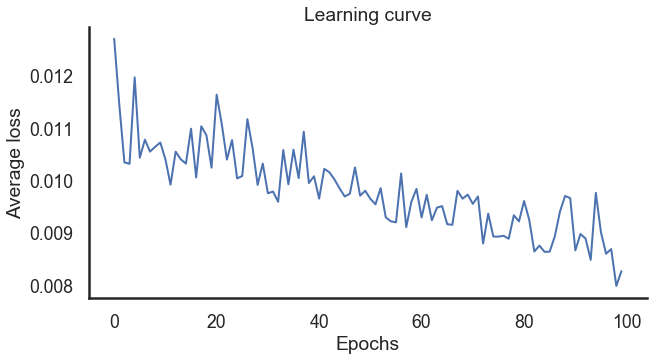

In [16]:
exec_id = rnn.default_execution_id

f, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(rnn.parameters.losses.get(exec_id))
ax.set_xlabel('Epochs')
ax.set_ylabel('Average loss')
ax.set_title('Learning curve')
sns.despine()

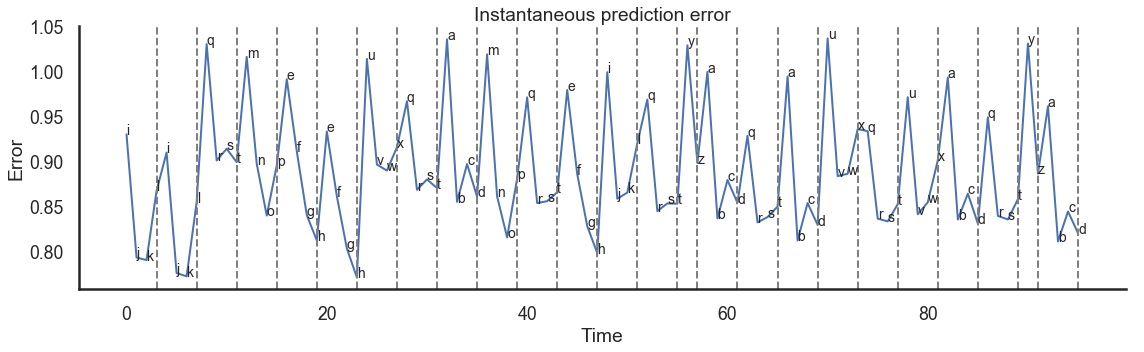

In [17]:
"""
in general, the error function over time peaks right after event(word) boundaries.
"""
# calculate error 
acts = np.squeeze(result)
error = [None] * (n_time_steps)
for t in range(n_time_steps): 
    error[t] = np.linalg.norm(X[t,:] - acts[t,:])

# plot 
word_boundaries = np.cumsum([len(vocab) for vocab in seq])-1
seq_letters = list(itertools.chain(*seq))
seq_len_test = len(seq_letters)

f,ax = plt.subplots(1,1, figsize=(16, 5))

ax.plot(np.arange(0,seq_len_test,1), error)

ax.set_title('Instantaneous prediction error')
ax.set_xlabel('Time')
ax.set_ylabel('Error')

for i, letter in enumerate(seq_letters):
    ax.annotate(letter, (i, error[i]), fontsize=14)

for wb in word_boundaries: 
    ax.axvline(wb, color='grey', linestyle='--')
    
sns.despine()
f.tight_layout()